In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

In [140]:
import leveldiagram as ld
from leveldiagram.utils import deep_update
from leveldiagram.artists import Coupling, WavyCoupling, EnergyLevel

In [26]:
DG = nx.DiGraph()
G = nx.Graph()
MDG = nx.MultiDiGraph()

In [12]:
lambda_nodes = ((0, {'energy':0, 'xpos':0, 'width':1}),
                (1, {'energy':1, 'xpos':1}),
                (2, {'energy':-0.1, 'xpos':2}))
lambda_edges = ((0,1,{'rabi':0.1, 'detuning':0}),
                (2,1,{'rabi':1, 'detuning':0}))

In [9]:
G.add_nodes_from(lambda_nodes)
G.add_edges_from(lambda_edges)

In [18]:
G.edges

EdgeView([(0, 1), (1, 2)])

In [27]:
DG.add_nodes_from(lambda_nodes)
DG.add_edges_from(lambda_edges)

In [14]:
DG.edges

OutEdgeView([(0, 1), (2, 1)])

In [15]:
MDG.add_nodes_from(lambda_nodes)
MDG.add_edges_from(lambda_edges)

[0, 0]

In [17]:
MDG.edges

OutMultiEdgeView([(0, 1, 0), (2, 1, 0)])

In [219]:
class LD():
    """
    Basic Level Diagram drawing class
    """
    
    # default options for artists
    level_defaults = {'width': 1, 'color':'k',
                      'text_kw':{'fontsize':'x-large'}}
    "EnergyLevel default parameters dictionary"
    
    coupling_defaults = {'arrowsize': 0.1,
                         'label_kw':{'fontsize':'large'}}
    "Coupling default parameters dictionary"
    
    wavycoupling_defaults = {'waveamp': 0.1, 'halfperiod': 0.1}
    "WavyCoupling default parameters dictionary"

    
    def __init__(self, graph, ax = None):
        """
        Parameters
        ----------
        
        graph: networkx.DiGraph or networkx.MultiDiGraph
            Graph object that defines the system to diagram
        ax: matplotlib.Axes, optional
            Axes to add the diagram to. If None, creates a new figure and axes.
            Default is None.
        """

        if ax is None:
            fig, ax = plt.subplots(1)
            ax.set_aspect('equal')
        self.fig = ax.get_figure()
        self.ax = ax
        
        self.ax.set_axis_off()
        
        self._graph = graph
        
        # control parameters
        default_label = 'left_text'
        """If note 'none', will use the node index inside a ket for the label.
        Value of parameter sets which text label direction to use.
        Valid options are 'left_text', 'right_text', 'top_text', 'bottom_text'.
        """
        
        # internal storage objects
        self.levels = {}
        self.couplings = {}
        
    def generate_levels(self):
        """
        Creates the EnergyLevel artists from the graph nodes.
        
        They are saved to the `LD.levels` dictionary.
        """
        
        for n in self._graph.nodes:
            node = self._graph.nodes[n].copy()
            # if x,y coords not defined, set using node index
            node.setdefault('energy', n)
            node.setdefault('xpos', n)
            
            if self.default_label != 'none':
                node.setdefault(self.default_label, ld.ket_str(n))
            
            # set default options
            node = deep_update(self.level_defaults, node)
            self.levels[n] = EnergyLevel(**node)
            
    def generate_couplings(self):
        """
        Creates the Coupling and WavyCoupling artisits from the graph edges.
        
        They are saved to the `LD.couplings` dictionary.
        """
        
        for ed in self._graph.edges:
            edge = self._graph.edges[ed].copy()
            # set default options
            edge = deep_update(self.coupling_defaults, edge)
            # pop off non-arguments
            det = edge.pop('detuning', 0)
            anchor = edge.pop('anchor', 'center')
            # set where couplings join the levels
            start = self.levels[ed[0]].get_anchor(anchor)
            stop = self.levels[ed[1]].get_anchor(anchor)
            # adjust for detuning
            stop[1] -= det
            edge.setdefault('start', start)
            edge.setdefault('stop', stop)
            
            if edge.pop('wavy', False):
                edge.update(self.wavycoupling_defaults)
                self.couplings[ed] = WavyCoupling(**edge)
            else:
                self.couplings[ed] = Coupling(**edge)
                
    def draw(self):
        """
        Add artists to the figure.
        """
        
        self.generate_levels()
        self.generate_couplings()
        
        for lev in self.levels.values():
            self.ax.add_line(lev)
            
        for coupling in self.couplings.values():
            self.ax.add_line(coupling)
            
        self.ax.autoscale_view()

TODO: Get auto-cycling colors for couplings working.

## Basic 3-level diagrams ##

In [190]:
lambda_nodes = ((0, {}),
                (1, {}),
                (2, {'energy':-0.1}))
lambda_edges = ((0,1,{'detuning':0.1, 'label':'probe'}),
                (2,1,{'label':'couple', 'lw':4, 'arrowsize':0.2}))
lambda_graph = nx.DiGraph()
lambda_graph.add_nodes_from(lambda_nodes)
lambda_graph.add_edges_from(lambda_edges)

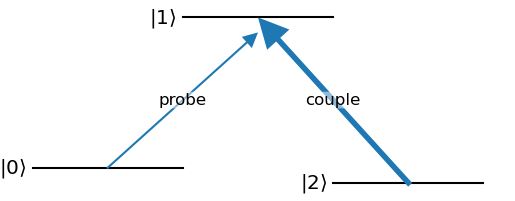

In [245]:
d = LD(lambda_graph)
d.draw()

In [177]:
ladder_nodes = (0,1,2)
ladder_edges = ((0,1,{'label':'probe'}),
                (1,2,{'label':'couple'}))
ladder_graph = nx.DiGraph()
ladder_graph.add_nodes_from(ladder_nodes)
ladder_graph.add_edges_from(ladder_edges)

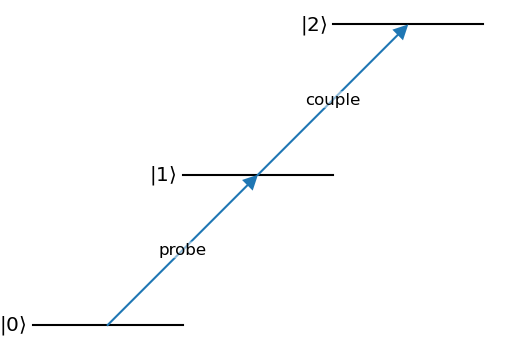

In [198]:
d = LD(ladder_graph)
d.draw()

In [203]:
v_nodes = ((0),
           (1,{'energy':1,'xpos':-1}),
           (2,{'energy':1, 'xpos':1}))
v_edges = ((0,1,{'label':'probe'}),
           (0,2,{'label':'couple'}))
v_graph = nx.DiGraph()
v_graph.add_nodes_from(v_nodes)
v_graph.add_edges_from(v_edges)

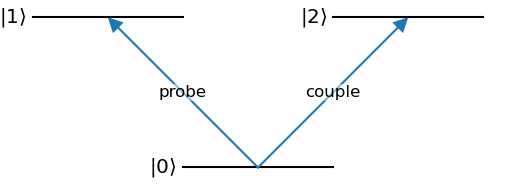

In [204]:
d = LD(v_graph)
d.draw()

## Hyperfine Diagram ##

In [263]:
hf_nodes =  [((f,i), {('top' if f==2 else 'bottom') + '_text':'$m_F='+f'{i:d}'+'$',
                      'energy':f-1,
                      'xpos':i,
                      'width':0.75,
                      'text_kw':{'fontsize':'large'}})
             for f in [1,2]
             for i in range(-f,f+1)]
lin_couples = [((1,i),(2,i),{'label':l,'color':'C0',
                            'label_kw':{'fontsize':'medium','color':'C0'}})
               for i,l in zip(range(-1,2), ['1/2','2/3','1/2'])]
sp_couples = [((1,i),(2,i+1),{'label':l,'color':'C1',
                              'label_offset':'right',
                             'label_kw':{'fontsize':'medium','color':'C1'}})
              for i,l in zip(range(-1,2), ['1/6','1/2','1'])]
sm_couples = [((1,i),(2,i-1),{'label':l, 'color':'C2',
                              'label_offset':'left',
                             'label_kw':{'fontsize':'medium','color':'C2'}})
              for i,l in zip(range(-1,2), ['1','1/2','1/6'])]
hf_edges = lin_couples + sp_couples + sm_couples
hf_graph = nx.DiGraph()
hf_graph.add_nodes_from(hf_nodes)
hf_graph.add_edges_from(hf_edges)

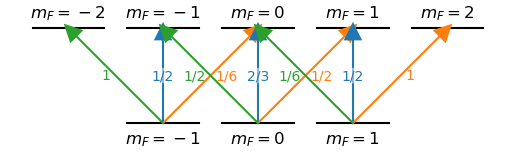

In [264]:
d = LD(hf_graph)
d.default_label = 'none'
d.ax.margins(y=0.2)
d.draw()

TODO: Think about how to easily adjust coupling text locations better...

## 4-wave Mixing Diagram ##

In [221]:
fwm_nodes = ((0),
             (1,{'xpos':-1}),
             (2,{'xpos':1,'energy':1}),
             (3,{'energy':2,'xpos':0}))
fwm_edges = ((0,1),
             (1,3),
             (3,2),
             (2,0,{'label':'idler', 'wavy':True}))
fwm_graph = nx.DiGraph()
fwm_graph.add_nodes_from(fwm_nodes)
fwm_graph.add_edges_from(fwm_edges)

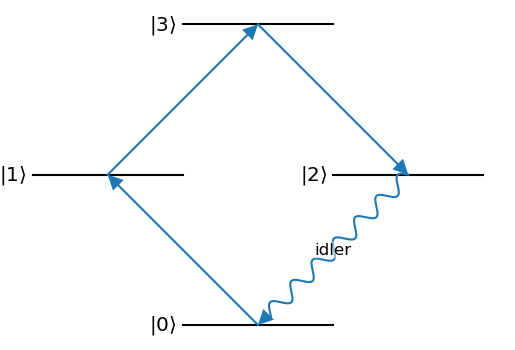

In [222]:
d = LD(fwm_graph)
d.draw()